# Loading Image Data
Using kaggle api - https://github.com/Kaggle/kaggle-api <br>
Install kaggle using - `pip install kaggle` <br>
Go to https://www.kaggle.com/c/dogs-vs-cats/data to download the cats and dogs data<br>
And using `kaggle competitions download -c dogs-vs-cats` <br>
Or use https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip <br>
Note: You need to accept the rules in kaggle and also use your phone number for validation.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

import helper

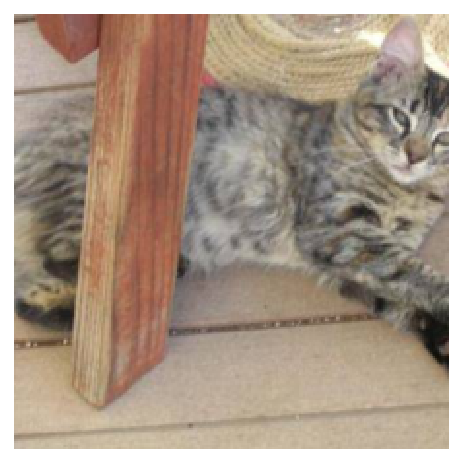

In [5]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder('Cat_Dog_data/train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

In [6]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

train_data = datasets.ImageFolder('Cat_Dog_data/train', transform=train_transforms)
test_data = datasets.ImageFolder('Cat_Dog_data/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


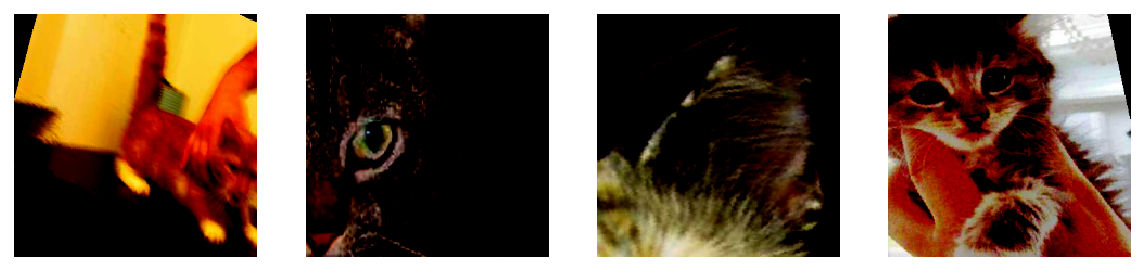

In [7]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

In [8]:
import torch
print(torch.__version__)

1.3.1


In [12]:
# Using pretrained models, mostly use 224x224 images. 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [14]:
data_dir = 'Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [15]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\rajas/.cache\torch\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:03<00:00, 10.2MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
# Freeze paramters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))  
                           ]))

model.classifier = classifier 

In [17]:
import time
for device in ['cpu', 'cuda']:
    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    model.to(device)
    for ii, (inputs, labels) in enumerate(trainloader):
        # Move input and label tensors to the GPU or CPU
        inputs, labels = inputs.to(device), labels.to(device)
        start = time.time()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if ii==3:
            break
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")    

Device = cpu; Time per batch: 3.594 seconds
Device = cuda; Time per batch: 0.014 seconds


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
# Trying Resnet model
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\rajas/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:10<00:00, 9.45MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# Turn off gradients for our model
for param in model.parameters():
    param.requires_grad = False
    
# Define our new classifier
classifier = nn.Sequential(nn.Linear(2048, 512),
                    nn.ReLU(),
                    nn.Dropout(p=0.2),
                    nn.Linear(512, 2),
                    nn.LogSoftmax(dim=1))
# Assign to fc in model
model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)        
                    logps = model.forward(images)
                    loss = criterion(logps, labels)
                    test_loss += loss.item()
                
                    # calculate our accuracy
                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every: .3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            running_loss = 0
            model.train()       

Epoch 1/1.. Train loss:  0.131.. Test loss: 0.049.. Test accuracy: 0.982
Epoch 1/1.. Train loss:  0.134.. Test loss: 0.050.. Test accuracy: 0.981
Epoch 1/1.. Train loss:  0.147.. Test loss: 0.070.. Test accuracy: 0.972
Epoch 1/1.. Train loss:  0.143.. Test loss: 0.057.. Test accuracy: 0.977
Epoch 1/1.. Train loss:  0.133.. Test loss: 0.059.. Test accuracy: 0.976
Epoch 1/1.. Train loss:  0.151.. Test loss: 0.063.. Test accuracy: 0.975
Epoch 1/1.. Train loss:  0.138.. Test loss: 0.052.. Test accuracy: 0.980
Epoch 1/1.. Train loss:  0.193.. Test loss: 0.043.. Test accuracy: 0.983
Epoch 1/1.. Train loss:  0.222.. Test loss: 0.048.. Test accuracy: 0.982
Epoch 1/1.. Train loss:  0.149.. Test loss: 0.066.. Test accuracy: 0.970
Epoch 1/1.. Train loss:  0.157.. Test loss: 0.046.. Test accuracy: 0.985
Epoch 1/1.. Train loss:  0.169.. Test loss: 0.044.. Test accuracy: 0.984
Epoch 1/1.. Train loss:  0.154.. Test loss: 0.040.. Test accuracy: 0.984
Epoch 1/1.. Train loss:  0.151.. Test loss: 0.047..

KeyboardInterrupt: 